# Exploring Cannabis tweets
Here we attempt to understand the topics used to describe/discuss Cannabis products on Twitter. The tweets for this analysis were mined from **1st May 2018, 00:00 hrs** to **31st Dec 2018, 23:59 hrs**. The keywords used to filter the tweets are:

- blunt
- bong
- budder
- cannabis
- cbd
- ganja
- hash
- hemp
- indica
- kush
- marijuana
- marihuana
- reefer
- sativa
- thc
- weed

From a total of **53177048** tweets and retweets (from **41612454** users) were collected. After removing the retweets, we were left with **19081081** tweets. We sampled out **102701** tweets (from **75751** unique users) from these 19 million tweets. After filtering out the tweets from bots, and non-english tweets we are left with **63679** tweets from **49581** users. After some more manual clean up to remove tweets that do not refer to cannabis products (eg. tweets that contain 'emily blunt' because 'blunt' was one of our keywords) we are left with **60861** tweets from **47760** unique users.

## Note on Sampling technique

### Expl 1
Since the tweets span over 8 months, we wish to maintain the temporal characteristics of the tweets when sampling. In order to do so, we first group the tweets by the week in which they were tweeted. For example, all tweets from May 1st 2018 to May 7th 2018 will clustered into temporal group 1, while tweets from May 8th 2018 to May 14th 2018 will belong to temporal group 2, and so on.

We will then sample proportionally from each group. Hence, if we wish to sample <code>N</code> tweets from the total <code>T</code> tweets (**19081081**), we sample <code>t<sub><em>i</em></sub></code> tweets from each group <code>g<sub><em>i</em></sub></code> of size <code>S<sub><em>i</em></sub></code> such that:
<pre>
t<sub><em>i</em></sub> = S<sub><em>i</em></sub> / T * N 
</pre>

We also wish to maintain keyword statistics i.e. our sampled population must have the same relative proportion of tweets containing each of our keywords (bong, blunt, etc.) as the total population. For example, if 10% of the tweets in our dataset contained tweets with the word "blunt" in it, 10% of our sample population should also contain tweets containing the word "blunt". In order to achive this, we break each temporal group <code>g<sub><em>i</em></sub></code> into multiple stratas: <code>s<sub><em>i<sub>k</sub></em></sub></code> for each keyword <code><em>k</em></code>.

We then sample proportionally from each strata (i.e. stratified sampling). Using stratified sampling along with temporal sampling, if we wish to sample <code>N</code> tweets from the total <code>T</code> tweets, we sample <code>n<sub><em>i<sub>k</sub></em></sub></code> tweets from each temporal group `i` and for each keyword `k` with a stara of size <code>S<sub><em>i<sub>k</sub></em></sub></code> such that:
<pre>
   n<sub><em>i<sub>k</sub></em></sub> = (S<sub><em>i</em></sub> / T) * (<code>S<sub><em>i<sub>k</sub></em></sub></code> / S<sub><em>i</em></sub>) * N
=> n<sub><em>i<sub>k</sub></em></sub> = <code>S<sub><em>i<sub>k</sub></em></sub></code> * N / T
</pre>

There are various ways to sample *N* items from *K* items with equal probability. We use [Reservoir Sampling](https://en.wikipedia.org/wiki/Reservoir_sampling).

### Expl2
Since the tweets span over 8 months and contain 16 keywords, we wish to maintain the temporal characteristics and the keyword statistics of the total population in the sampled tweets too.

The temporal characteristics of the dataset refers to the histogram of the tweets over each week. If 5% of the tweets in the dataset were tweeted in the first week of October, then 5% of our sampled population should also be tweets from the first week of October.

The keyword statistics of the dataset refers to the proportion of tweets contributed by mining each keyword (blunt, weed, etc.). In order to maintain the same, if 10% of the tweets in the dataset contain the word "blunt", then 10% of the sampled poplulation should also contain the word "blunt".

There are various ways to sample <code>N</code> items from <code>T</code> items with equal probability. We use [Reservoir Sampling](https://en.wikipedia.org/wiki/Reservoir_sampling). In order to maintain our temporal and keyword statistics, this we follow the following algorigthm:
<pre><em>
Let <strong>D</strong> be the tweet dataset;
Let <strong>T</strong> be the number of tweets in <strong>D</strong>;
Let <strong>N</strong> be the number of tweets to sample;

Group all tweets by the week they were tweeted. Let the set of all groups be called <strong>G</strong>.
For each group <strong>g</strong> in <strong>G</strong>:
    Divide <strong>g</strong> into 16 stratas per keyword. Let <strong>S</strong> be the set of all stratas of <strong>g</strong>.
    For each strata <strong>s</strong> in <strong>S</strong>:
        Sample <strong>n</strong> tweets using Reservoir Sampling such that,
        <strong>n = (number of tweets in s) * N / T</strong>
</em></pre>

In [1]:
import itertools as it
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import os
import string

from collections import Counter
from types import SimpleNamespace
from wordcloud import WordCloud

NON_BOT_TWEET_FILE = '../data/Tweets/cleanNonBotTweets.pickle'
BOT_TWEET_FILE = '../data/Tweets/cleanBotTweets.pickle'

stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)
CANNABIS_KEYWORDS = [
    'blunt', 'bong', 'budder', 'cannabis',
    'cbd', 'ganja', 'hash', 'hemp',
    'indica', 'kush', 'marijuana', 'marihuana',
    'reefer', 'sativa', 'thc', 'weed'
]

## Loading the data
The tweets are loaded from the disk and we find frequent onegrams and bigrams in the tweets. In order to create an n-gram, we perform a number of transformation:

- **Basic normalization:** Lower case all tweets, remove extra spaces, remove punctuation between words, and remove special characters such as brackets, etc.
- **Stop word removal:** Words such as 'a', 'the', etc. are heavily represented in the English language. Such words add to the syntax, but rarely add to the meaning of the sentence. To make analysis easier, we ignore these words.
- **Normalizing twitter user mentions:** In twitter @person_name is used to tag people, and pages in your post. The name of each person tagged has little importance to us, but we would like to maintain statistics on the number of people tagged. Therefore, all @xyz occurrences in the tweets have been replaced by @person - a common token for all people.
- **Lemmatization:** Words such as 'walked', and 'walk' should be conflated in our analysis, so we would like to break down words into their basic form by removing inflections, and variants.
- **Non-printable character removal:** Unicode characters in tweets are often used for emoticons, or as symbols from other languages. Since we are dealing with tweets in English, we can remove these symbols without much loss in the meaning of the sentence.
- **Remove hashtags, and urls in the tweet**: Hashtags are useful for filtering out tweets which relate to a group (like e-juices), but don't add much value when trying to divide the group into topics. URLs embedded in the tweet are usually links to images (which on twitter are shown as embedded images), and external links to other websites. Since not much can be said about a website just from its URL, we can discard it.

In [2]:
def load_tweets(tweet_file):
    with open(tweet_file, 'rb') as file_handle:
        return pickle.load(file_handle)

non_bot_tweets = load_tweets(NON_BOT_TWEET_FILE)
bot_tweets = load_tweets(BOT_TWEET_FILE)

### Post-Cleanup
During the analysis we found multiple entities not talking about cannabis containing the keywords we used to mine the tweets. Here we remove the tweets containing the most entities.

For example,
- 'blunt' is the surname of two popular actors "James Blunt", and "Emily Blunt"
- 'hash' could also refer to a cryptographic hash, the hash symbol (used in hashtags), or simply hash browns.

We remove references to the above mentioned entities by finding common patterns refering to them (in the case of names, the full names suffices as a pattern).

In [3]:
def classify(tweets, ngram_pattern, log=True):
    """
    Returns the set of tweets ids that match the specified patterns.
    """
    results = set()
    for tweet in tweets.itertuples():
        for pattern in ngram_pattern:
            include = False
            if type(pattern) == str:
                include = pattern in tweet.NormalizedText
            elif type(pattern) == list:
                start = 0
                for word in pattern:
                    for i in range(start, len(tweet.NormalizedText)):
                        if word == tweet.NormalizedText[i]:
                            start = i
                            break
                    else:
                        break
                else:
                    include = True
            elif type(pattern) == tuple:
                if any(ngram == pattern for ngram in nltk.ngrams([t for t in tweet.NormalizedText if t not in stopwords], len(pattern))):
                    include = True
            if include:
                results.add(tweet.Id)
                break
    num_selected = len(results)
    if log:
        print(f'Num of tweets matched: {num_selected} (%.2f%%)' % (num_selected / tweets.shape[0] * 100))
    return results

In [4]:
post_cleanup_patterns = [
    ['james', 'blunt'],                      # singer
    ['emily', 'blunt'],                      # actress
    ['jenna', 'sativa'], ['sativa', 'rose'], # "actresses"
    ['block', 'hash'],                       # blockchain tweets (hash refers to cryptographic hash)
    ('hash', 'brown'), ('hash', 'browns'),   # most talk about the actual dish
    ('hash', 'tag'), ('hash', 'tags'),       # hashtags in twitter
    ('bong', 'bong'),                        # from the Big Ben's unofficial twitter account
    ('carat', 'bong'),                       # A concert light product
    ('bing', 'bong'),                        # Just a phrase
    ('bong', 'go'),                          # A Filipino politician
    'porn'
]

non_bot_tweets = non_bot_tweets[~non_bot_tweets.Id.isin(classify(non_bot_tweets, post_cleanup_patterns))]
print(f'Remaining # of tweets: {non_bot_tweets.shape[0]}. Remaining # of user: {non_bot_tweets.UserId.unique().shape[0]}')

bot_tweets = bot_tweets[~bot_tweets.Id.isin(classify(bot_tweets, post_cleanup_patterns))]
print(f'Remaining # of tweets: {bot_tweets.shape[0]}. Remaining # of user: {bot_tweets.UserId.unique().shape[0]}')

Num of tweets matched: 2818 (4.43%)
Remaining # of tweets: 60861. Remaining # of user: 47760
Num of tweets matched: 188 (2.07%)
Remaining # of tweets: 8874. Remaining # of user: 2871


### Generating n-grams
In order to find topics within our tweets, we generate 1-grams and 2-grams from each tweet. N-grams that are popular among tweets can help us identify popular topics of discussion.
For example,
    Sentence: "A quick brown fox jumps."
    1-grams : "a", "quick", "brown", "fox", and "jumps"
    2-grams : "a quick", "quick brown", "brown fox", and "fox jumps"

In [5]:
def gen_ngrams(tweets):
    onegrams, bigrams = {}, {}
    for text in tweets.NormalizedText:
        seen = set()
        prev = None
        for word in text:
            if word in punctuation or word.isdigit() or word in stopwords or word[0] == '#':
                continue
            if word not in onegrams:
                onegrams[word] = 1
            elif word not in seen:
                onegrams[word] += 1
            seen.add(word)
            if prev is not None:
                bigram = '-'.join([prev, word])
                if bigram not in bigrams:
                    bigrams[bigram] = 1
                elif bigram not in seen:
                    bigrams[bigram] += 1
                seen.add(bigram)
            prev = word
    onegrams = pd.DataFrame.from_dict(onegrams, orient='index', columns=['Freq'])
    onegrams.sort_values(by=['Freq'], ascending=False, inplace=True)
    bigrams = pd.DataFrame.from_dict(bigrams, orient='index', columns=['Freq'])
    bigrams.sort_values(by=['Freq'], ascending=False, inplace=True)
    return SimpleNamespace(tweets=tweets, onegrams=onegrams, bigrams=bigrams)

In [6]:
dfs = gen_ngrams(non_bot_tweets)
bot_dfs = gen_ngrams(bot_tweets)

## Exploration through word clouds
By generating word clouds for the most common onegrams and bigrams we can get a feel of the common topics discussed by people. The word cloud displays the most popular n-grams. More popular n-grams are larger than less popular ones.

In [7]:
import matplotlib.pyplot as plt

def create_wordCloud(freqDict, w=800, h=600):
    wc = WordCloud(width=w, height=h).generate_from_frequencies(freqDict)
    plt.figure(figsize=(30,30))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### 1-gram word cloud

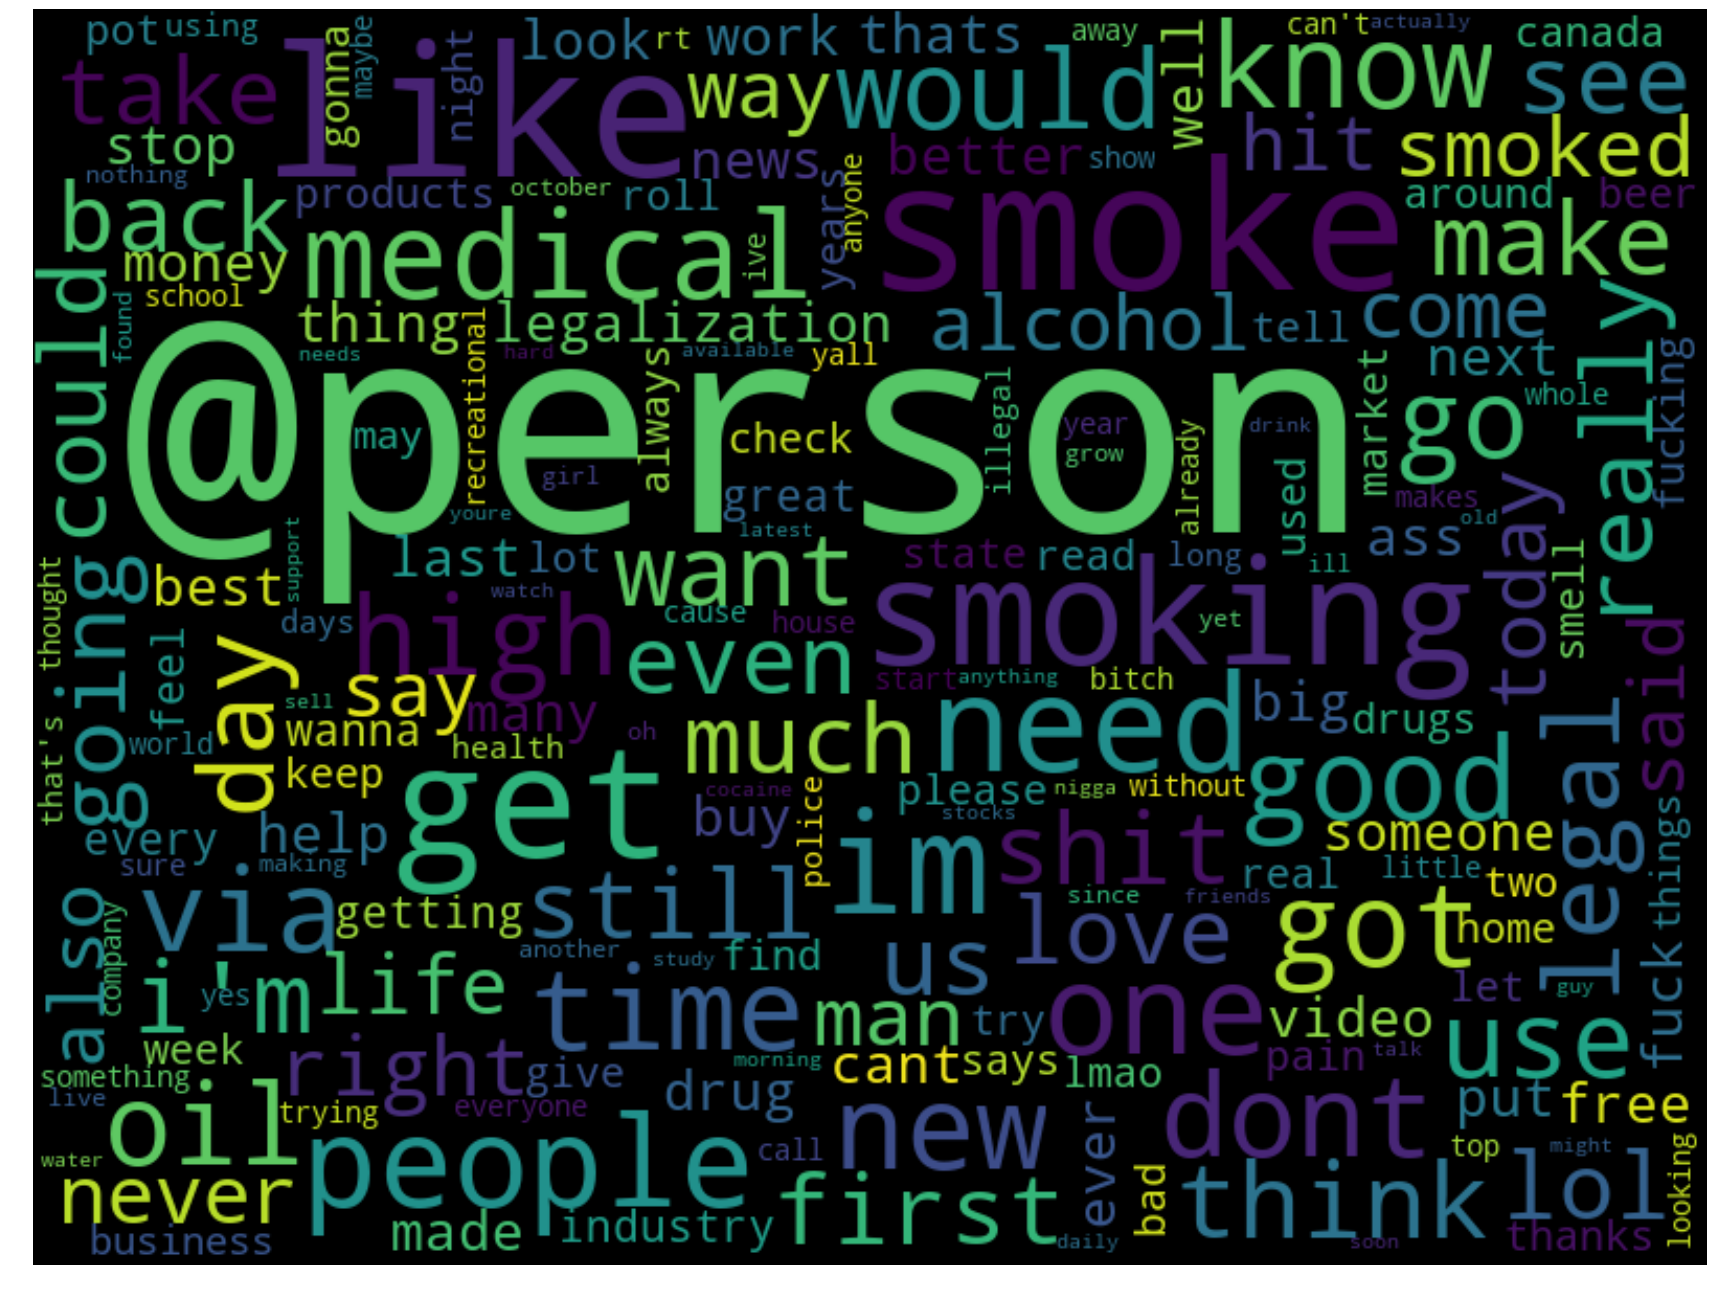

In [8]:
create_wordCloud(dfs.onegrams[~dfs.onegrams.index.isin(CANNABIS_KEYWORDS)].to_dict()['Freq'])

### 2-gram word cloud

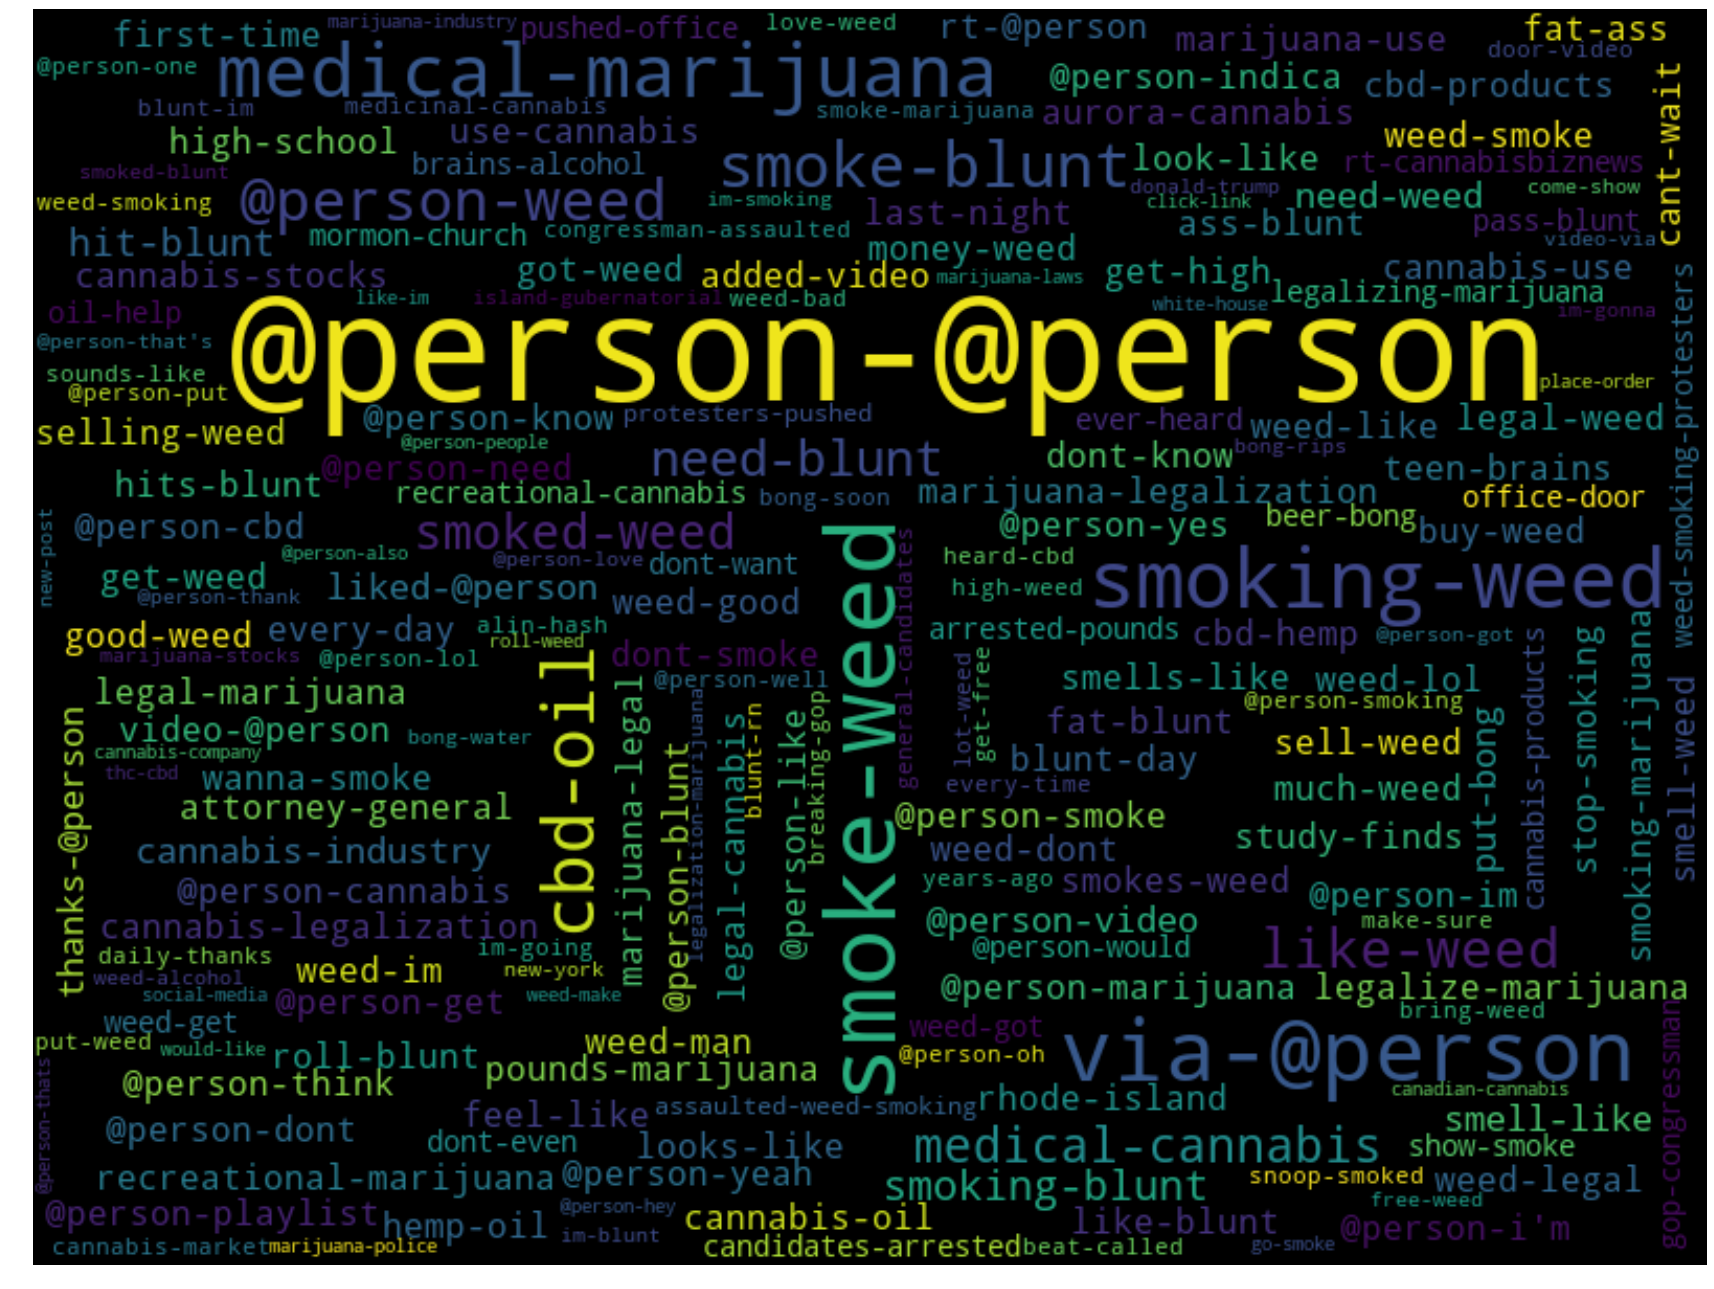

In [9]:
create_wordCloud(dfs.bigrams.to_dict()['Freq'])

One topic that stands out in the bigram word cloud is person tagging (bigrams containing @person). In order to help highlight other topics, let's have a look at a word cloud without it.

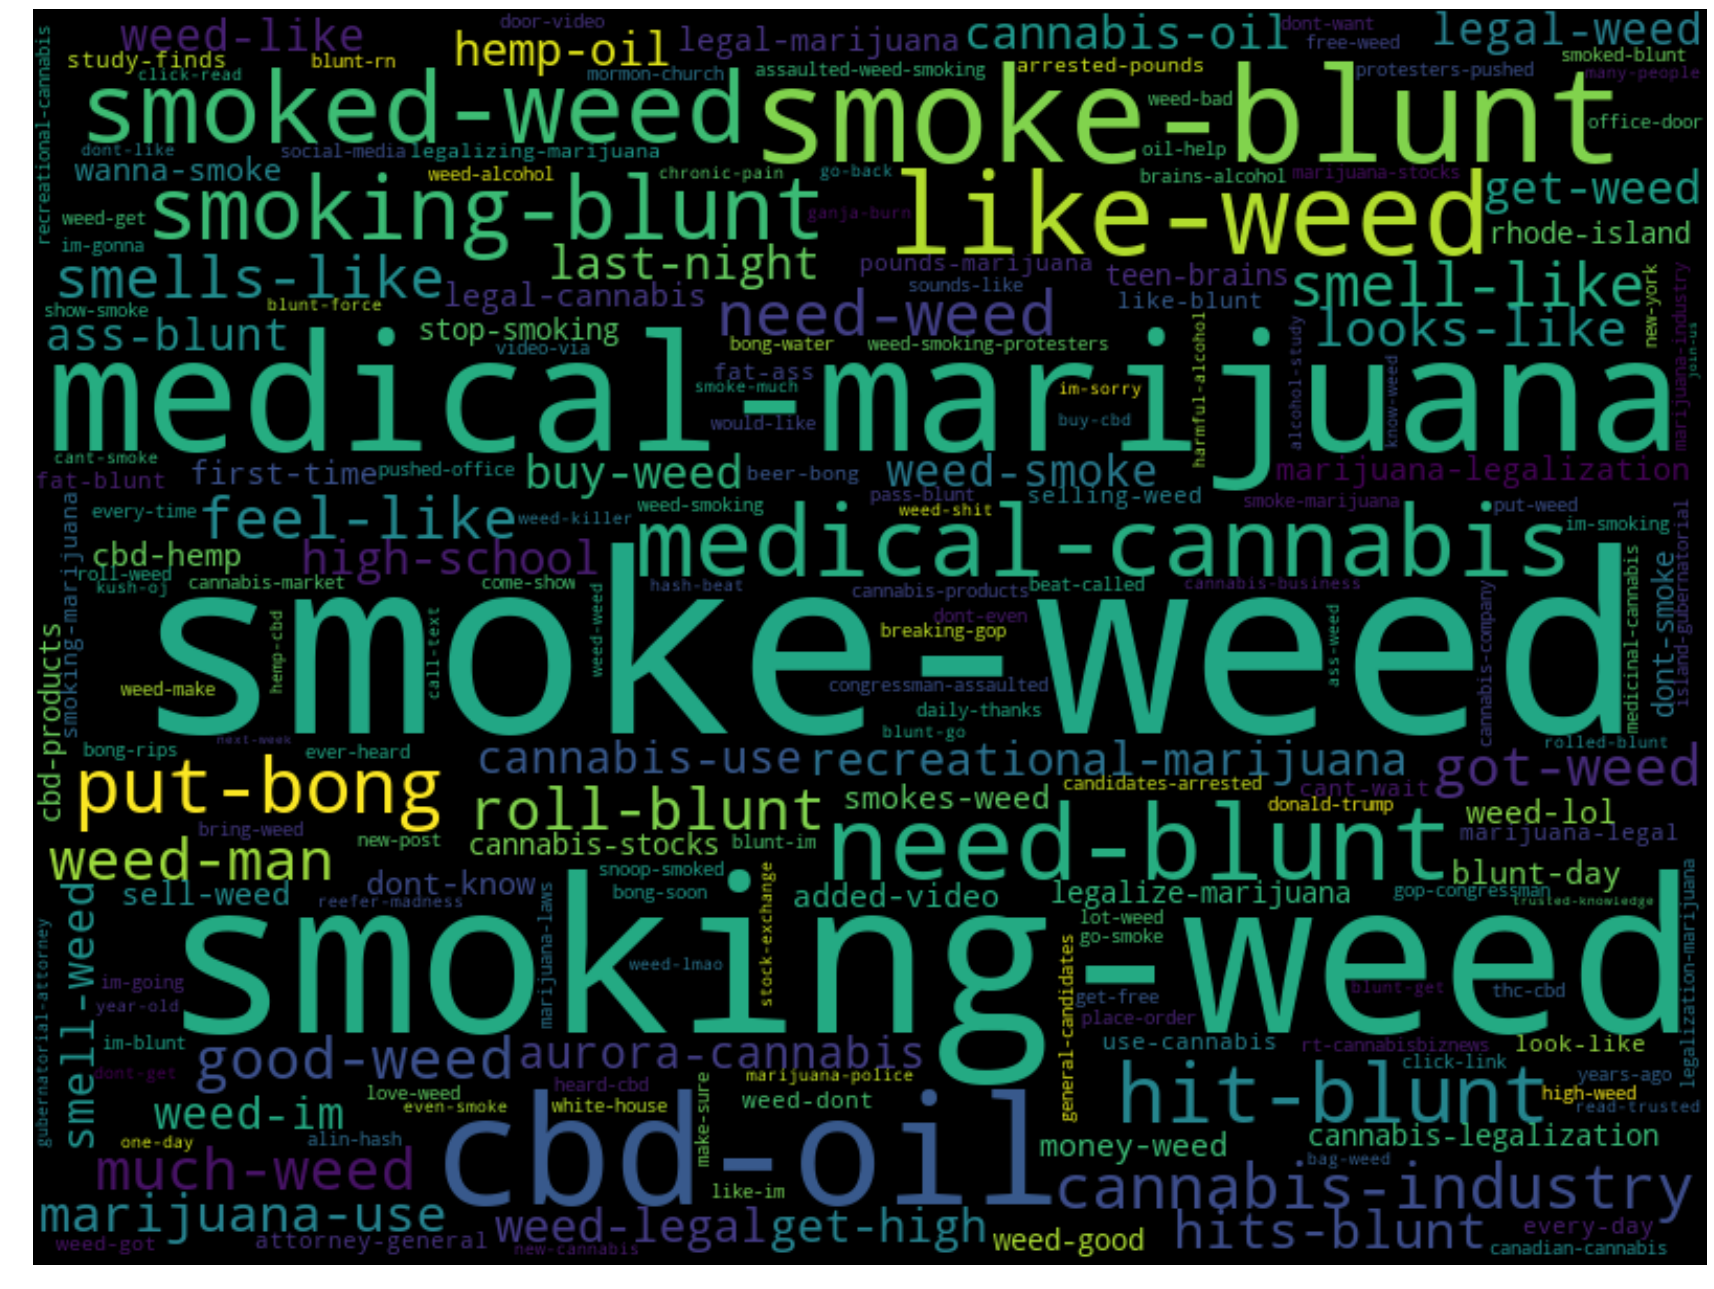

In [10]:
create_wordCloud(
    dfs.bigrams[dfs.bigrams.index.map(lambda x: '@person' not in x)].to_dict()['Freq']
)

## Classify tweets into topics
From the wordclouds we can identify a few commonly occuring topics. Eg: product sale, cannabis usage by people, etc. Using the n-grams in the wordclouds as seeds, we can find other identifiers for a topic be looking for n-grams similar to or co-occuring with the seed.

In order to classify a tweet into a topic we search for a list of n-grams that represent the topic within each tweets. If at least one n-gram matches, the tweet is considered a member of the topic.

**Interpretting the patterns:**
There are 3 kinds of patterns used in the code blocks below:
    - 'some_word': This pattern matches all tweets that contain the word 'some_word'.
    - ('word1', 'word2'): This pattern matches all tweets that contain the 2-gram 'word1 word2'.
    - \['word1', 'word2'\]: This pattern matches all tweets that contain 'word1' followed by 'word2' somewhere within the tweet. For example: \['quick', 'fox'\] matches "The quick brown fox", and "The quick fox was tired", but not "The fox was quick".
    
**Interpretting results:**
The results in the below blocks displays the number of tweets matched by the patterns, and the percentage of the total tweets matched by the patterns.

### Buy/sell
This topic contains tweets that discuss the sale and purchase of cannabis related products.

In [11]:
buy_sell_patterns = [
    'buy', 'buying', 'pay', 'purchase',
    'sell', 'selling', 'sale', 'dispensary',
    'afford', 'affordable', 'discount', 'order',
    ('get', 'weed'), ('weed', 'man'),
    ('cannabis', 'delivery'), ('delivery', 'service'), ('weed', 'delivery'), ('delivery', 'door'),
    ('discreet', 'delivery'), ('bong', 'delivery'),
]
buy_sell = classify(dfs.tweets, buy_sell_patterns)

Num of tweets matched: 3051 (5.01%)


### Appeal or Abuse liability
This topic contains tweets discussing the need to use cannabis products.

In [12]:
abuse_patterns = [
    ('need', 'blunt'),
    ('get', 'high'),
    ('need', 'weed'),
    ('like', 'weed'),
    ('love', 'weed'),
    ('wanna', 'smoke'), 
]
abuse = classify(dfs.tweets, abuse_patterns)

Num of tweets matched: 1614 (2.65%)


### Using Cannabis
This topic relates to tweets that talk about casual usage of cannabis.

In [13]:
usage_patterns = [
    ('smoking', 'weed'), ('smoke', 'weed'), ('smokes', 'weed'), ('smoke', 'blunt'),
    ('smoked', 'weed'), ('smoking', 'blunt'), ('hit', 'blunt'), ('roll', 'blunt'),
    ('rolled', 'blunt'), ('good', 'weed'), ('got', 'weed'), ('hits', 'blunt'),
    ('cannabis', 'use'), ('first', 'time'), ('blunt', 'day'),
    ('use', 'cannabis'), ('smoking', 'marijuana'), ('pass', 'blunt'), ('rolling', 'blunt'),
    'recreational'
]
usage = classify(dfs.tweets, usage_patterns)

Num of tweets matched: 7235 (11.89%)


#### Initiation
We also attempt to find tweets that indicate initiation of smoking cannabis within the `Using Cannabis` topic.

In [14]:
initiation = classify(
    dfs.tweets[dfs.tweets.Id.isin(usage)],
    [
        ('first', 'time'), ('first', 'smoke'), ('first', 'blunt'), ('started', 'smoking')
    ]
)

Num of tweets matched: 189 (2.61%)


Around 2.6% of the `Using cannabis` tweets indicate inititaiton.

### Processed product usage
Usage of processed products derived from cannabis (except oils).

In [15]:
processed_product_usage_patterns = [
    'edible', 'wax', 'dab', 'dabs',
    'shatter', 'vape', 'pills', 'tincture',
    'tincture-discreet', 'e-liquid', 'lotion', 'pen',
    'topical', 'creams', 'salves', 'cannadrink',
    'cbd-e-liquids', 'cbd-products', 'wax-hash', 'wax',
    'hash', 'hashish', 'wax',
]
processed_product_usage = classify(dfs.tweets, processed_product_usage_patterns)

Num of tweets matched: 2260 (3.71%)


### CBD and Hemp Use
Tweets discussing the usage of cannabis oils and hemp infused products.

In [16]:
hemp_oil_patterns = [
    ('cbd', 'drink'), ('hemp', 'oil'), ('cbd', 'oil'), ('hemp', 'oil'),
    ('cannabis', 'oil'), ('seed', 'oil'), ('thc', 'oil'), ('hash', 'oil'),
    ('buds', 'oils'), ('oil', 'tincture,'), ('try', 'cbd'), ('use', 'cbd'),
    ('using', 'cbd'), ('cbd', 'vape'), ('taking', 'cbd'), ('cbd', 'gummies'),
    ('cbd', 'infused'), ('cbd', 'beverage'), ('cbd', 'capsules'), ('cbd', 'infused'),
    ('infused', 'drinks'), ('infused', 'drink'), ('take', 'cbd')
]
hemp_oil = classify(dfs.tweets, hemp_oil_patterns)

Num of tweets matched: 1661 (2.73%)


### Health and Medical
This topic talks about usage of medical marijuana, and the usage of marijuana to treat health problems. 

In [17]:
medical_patterns = [
    'medical', 'medicinal', 'pain', 'anxiety',
    'depression', 'trauma', 'ptsd', 'cancer',
    ("weed", "helps"), 
    ("cbd", "helps"), 
    ("marijuana", "helps"),
    ("thc", "helps"), 
    ("helps", "sleep"), 
    ("know", "helps"),
    ("benefits", "cbd"),
]
medical = classify(dfs.tweets, medical_patterns)

Num of tweets matched: 3416 (5.61%)


### Legality
This topic deals with tweets discussing marijuana legalization.

In [18]:
legal_patterns = [
    'legal', 'legalize', 'legalizing', 'legalization', 'illegal',
    ('marijuana', 'laws'), ('marijuana', 'police')
]
legal = classify(dfs.tweets, legal_patterns)

Num of tweets matched: 3345 (5.50%)


### Polysubstance Use
Tweets that discuss the usage of marijuana along with other substances.

In [19]:
polysubstance_use_patterns = [
    'beer', 'wine', 'vodka', 'tequila', 'shots',
    'xanax', 'shrooms', 'cigarette', 'cigarettes', 'meth',
    'coke', 'lsd', 'ecstacy', 'ecstasy', 'psychedelics', 'heroin', ('cocaine', 'delivery')
]
polysubstance_use = classify(dfs.tweets, polysubstance_use_patterns)

Num of tweets matched: 1504 (2.47%)


### Person tagging
As seen before, a lot of tweets have people tagged in them. This illustrates a social intent behind the tweet. This topic is by far the single largest topic in the analysis.

In [20]:
person_tagging_patterns = ['@person']
person_tagging = classify(dfs.tweets, person_tagging_patterns)

Num of tweets matched: 20450 (33.60%)


### Underage use
This topic tries to capture mentions of unerdage smoking of weed, or discussions around it.

In [21]:
underage_patterns = [
    'school', 'teen', 'teenage'
]
underage = classify(dfs.tweets, underage_patterns)

Num of tweets matched: 722 (1.19%)


**This tweets found above are heavy on discussion around a single news article about effects of cannabis on teenage brains. So maybe it isn't very useful. The discussion is also confined to only the first week of October.**

Thus we discard these tweets, and instead use more conservative phrases that mention underage usage.

In [22]:
underage_patterns = [
    ('high', 'school'), ('middle', 'school'),
    ('kids', 'smoke'), ('kids', 'smoking'),
    ('blunt', 'kids')
]
underage = classify(dfs.tweets, underage_patterns)

Num of tweets matched: 215 (0.35%)


### Impairment and usage in workplace
This topic captures tweets talking about impairment due to use of cannabis, and the usage of cannabis in the workplace.

In [23]:
impairment_patterns = [
    'workplace',
    'impair',
    'impairs',
    'impaired', 
    'impairment',
    ("driving", "influence"), 
    ("influence", "weed,"), 
    ['working', 'weed'], ['weed', 'working'],
    ['smoke', 'work'], ['smoke', 'working'], ['smoke', 'job']
]
impairment = classify(dfs.tweets, impairment_patterns)

Num of tweets matched: 288 (0.47%)


### Cannabis Industry
Tweets that talk about the state of the cannabis industry.

In [24]:
cannabis_industry_patterns = [
    ('cannabis', 'industry'), ('marijuana', 'industry'), ('hemp', 'industry'), ('weed', 'industry'), ('cbd', 'indutry'),
    ('cannabis', 'stock'), ('cannabis', 'stocks'), ('marijuana', 'stock'), ('marijuana', 'stocks'),
    ('cannabis', 'market'), ('cannabis', 'markets'), ('marijuana', 'market'), ('hemp', 'market'), ('cbd', 'market')
]
cannabis_industry = classify(dfs.tweets, cannabis_industry_patterns)

Num of tweets matched: 808 (1.33%)


## Confusion matrix
Since our topics overlap with each other, it will be useful to see the percentage of overlap between each topic. A confusion matrix is an useful visualization tool for this purpose.

Each cell in the matrix represents the intersection of two topics. The value of the cell represents the percentage of the total corpus which belong to both topics. For example, in the table below, the cell at the intersection of the Flavors column, and Promotional row represents the tweets which are promotional AND talk about the flavors available. The table shows that `1241` tweets i.e. `2.00%` of the total `62078` tweets belong to this intersection.

In [25]:
def conf_matrix(classifications, tweets):
    total_tweets_classified = set(it.chain(*classifications.values()))
    total_tweets = tweets.shape[0]
    result = []
    for key1 in classifications:
        intersections = [key1]
        for key2 in classifications:
            intersection = classifications[key1] & classifications[key2]
            intersections.append('%s, %0.2f%%' % (len(intersection), len(intersection) / total_tweets * 100))
        result.append(intersections)
    total_tweets_classified_len = len(total_tweets_classified)
    print(f'Total classified: {total_tweets_classified_len} ({total_tweets_classified_len / total_tweets * 100}%)')
    negatives = tweets[~tweets.Id.isin(total_tweets_classified)]
    return pd.DataFrame(result, columns=['vs', *classifications.keys()]).set_index('vs'), negatives

topics = {
    'Person Tagging': person_tagging,
    'Using Cannabis': usage,
    'Health and Medical': medical,
    'Legality': legal,
    'Buy/Sell': buy_sell,
    'Processed Product Usage': processed_product_usage,
    'CBD and Hemp Use': hemp_oil,
    'Appeal or Abuse Liability': abuse,
    'Polysubstance Use': polysubstance_use,
    'Cannabis Industry': cannabis_industry,
    'Impairment': impairment,
    'Underage Use': underage
}

_, negatives = conf_matrix(topics, dfs.tweets)

_

Total classified: 35386 (58.14232431277829%)


Person Tagging Using Cannabis Health and Medical  \
vs                                                                           
Person Tagging             20450, 33.60%    1965, 3.23%        1231, 2.02%   
Using Cannabis               1965, 3.23%   7235, 11.89%         218, 0.36%   
Health and Medical           1231, 2.02%     218, 0.36%        3416, 5.61%   
Legality                     1434, 2.36%     274, 0.45%         279, 0.46%   
Buy/Sell                      939, 1.54%     136, 0.22%         193, 0.32%   
Processed Product Usage       948, 1.56%      62, 0.10%         127, 0.21%   
CBD and Hemp Use              503, 0.83%      11, 0.02%         345, 0.57%   
Appeal or Abuse Liability     267, 0.44%     160, 0.26%          29, 0.05%   
Polysubstance Use             621, 1.02%     242, 0.40%          42, 0.07%   
Cannabis Industry             217, 0.36%      22, 0.04%          34, 0.06%   
Impairment                    107, 0.18%      77, 0.13%          12, 0.02%   
Underage Use                   87, 0.14%      68, 0.11%           2, 0.00%   

                              Legality     Buy/Sell Processed Product Usage  \
vs                                                                            
Person Tagging             1434, 2.36%   939, 1.54%              948, 1.56%   
Using Cannabis              274, 0.45%   136, 0.22%               62, 0.10%   
Health and Medical          279, 0.46%   193, 0.32%              127, 0.21%   
Legality                   3345, 5.50%   201, 0.33%               71, 0.12%   
Buy/Sell                    201, 0.33%  3051, 5.01%              183, 0.30%   
Processed Product Usage      71, 0.12%   183, 0.30%             2260, 3.71%   
CBD and Hemp Use             53, 0.09%   177, 0.29%              165, 0.27%   
Appeal or Abuse Liability    15, 0.02%    51, 0.08%               17, 0.03%   
Polysubstance Use            79, 0.13%    60, 0.10%               44, 0.07%   
Cannabis Industry            75, 0.12%    47, 0.08%                1, 0.00%   
Impairment                   32, 0.05%    13, 0.02%                6, 0.01%   
Underage Use                  6, 0.01%    17, 0.03%                7, 0.01%   

                          CBD and Hemp Use Appeal or Abuse Liability  \
vs                                                                     
Person Tagging                  503, 0.83%                267, 0.44%   
Using Cannabis                   11, 0.02%                160, 0.26%   
Health and Medical              345, 0.57%                 29, 0.05%   
Legality                         53, 0.09%                 15, 0.02%   
Buy/Sell                        177, 0.29%                 51, 0.08%   
Processed Product Usage         165, 0.27%                 17, 0.03%   
CBD and Hemp Use               1661, 2.73%                 10, 0.02%   
Appeal or Abuse Liability        10, 0.02%               1614, 2.65%   
Polysubstance Use                18, 0.03%                 20, 0.03%   
Cannabis Industry                 7, 0.01%                  2, 0.00%   
Impairment                        0, 0.00%                  5, 0.01%   
Underage Use                      0, 0.00%                  3, 0.00%   

                          Polysubstance Use Cannabis Industry  Impairment  \
vs                                                                          
Person Tagging                   621, 1.02%        217, 0.36%  107, 0.18%   
Using Cannabis                   242, 0.40%         22, 0.04%   77, 0.13%   
Health and Medical                42, 0.07%         34, 0.06%   12, 0.02%   
Legality                          79, 0.13%         75, 0.12%   32, 0.05%   
Buy/Sell                          60, 0.10%         47, 0.08%   13, 0.02%   
Processed Product Usage           44, 0.07%          1, 0.00%    6, 0.01%   
CBD and Hemp Use                  18, 0.03%          7, 0.01%    0, 0.00%   
Appeal or Abuse Liability         20, 0.03%          2, 0.00%    5, 0.01%   
Polysubstance Use               1504, 2.47%    

## Person Tagging Deepdive
Here we take a look deeper look at those tweets classified as a 'person tagging' tweet. Since there is a large overlap between the person tagging tweets, and the other topics, we will look for new topics common among only person tagging tweets by first removing all overlapping tweets.

In [26]:
person_tagging_df = dfs.tweets[dfs.tweets.Id.isin(person_tagging)]

def remove_classified(tweets, to_remove):
    result = tweets
    for x in to_remove:
        result = result[~result.Id.isin(x)]
    return result

person_negatives = remove_classified(person_tagging_df, [
    usage, medical, legal, buy_sell,
    processed_product_usage, hemp_oil, polysubstance_use, abuse,
    underage, impairment
])

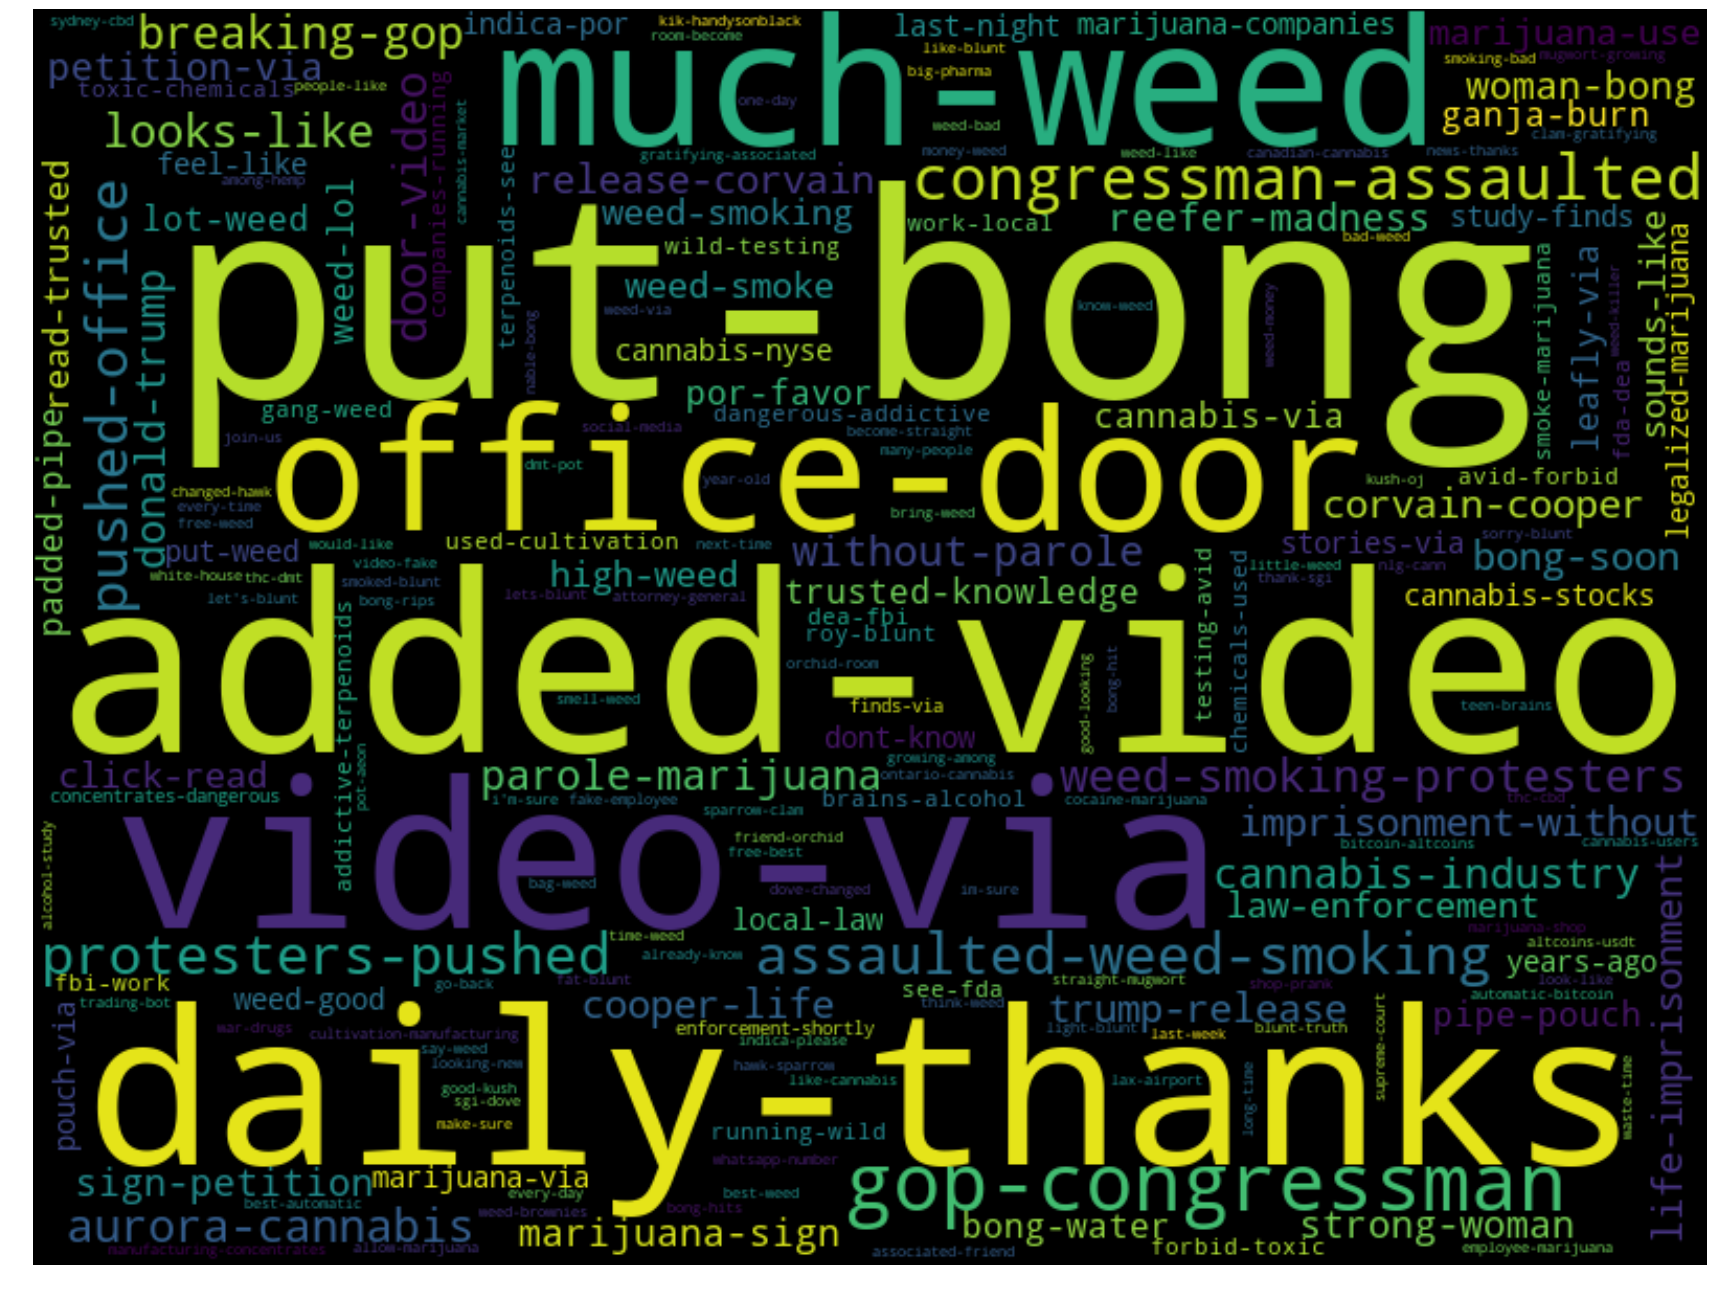

In [27]:
person_tagging_ngrams = gen_ngrams(person_negatives)
create_wordCloud(person_tagging_ngrams.bigrams.filter(regex="^[^@]+$", axis=0).to_dict()['Freq'])

#### Media
People are often tagged on links to videos or pictures of smoking, or cannabis products.

In [28]:
person_media_patterns = [
    'photo', 'photos', 'pic', 'pics', 'video', 'videos', 'youtube'
]
person_media = classify(person_tagging_df, person_media_patterns)

Num of tweets matched: 653 (3.19%)


#### Confusion matrix

In [29]:
_, person_negatives = conf_matrix({key: classify(person_tagging_df, value, False) for key, value in {
    'Using Cannabis': usage_patterns,
    'Health and Medical': medical_patterns,
    'Legality': legal_patterns,
    'Buy/Sell': buy_sell_patterns,
    'Processed Product Usage': processed_product_usage_patterns,
    'CBD and Hemp Use': hemp_oil_patterns,
    'Polysubstance Use': polysubstance_use_patterns,
    'Appeal or Abuse Liability': abuse_patterns,
    'Underage Use': underage_patterns,
    'Impairment': impairment_patterns,
    'Media': person_media_patterns
}.items()}, person_tagging_df)

_

Total classified: 7394 (36.15647921760391%)


Using Cannabis Health and Medical     Legality  \
vs                                                                         
Using Cannabis               1965, 9.61%          68, 0.33%   111, 0.54%   
Health and Medical             68, 0.33%        1231, 6.02%   107, 0.52%   
Legality                      111, 0.54%         107, 0.52%  1434, 7.01%   
Buy/Sell                       34, 0.17%          75, 0.37%    99, 0.48%   
Processed Product Usage        27, 0.13%          69, 0.34%    56, 0.27%   
CBD and Hemp Use                4, 0.02%         136, 0.67%    15, 0.07%   
Polysubstance Use              94, 0.46%          26, 0.13%    41, 0.20%   
Appeal or Abuse Liability      25, 0.12%          16, 0.08%     7, 0.03%   
Underage Use                   27, 0.13%           0, 0.00%     1, 0.00%   
Impairment                     28, 0.14%           3, 0.01%    11, 0.05%   
Media                          61, 0.30%          23, 0.11%    13, 0.06%   

                             Buy/Sell Processed Product Usage  \
vs                                                              
Using Cannabis              34, 0.17%               27, 0.13%   
Health and Medical          75, 0.37%               69, 0.34%   
Legality                    99, 0.48%               56, 0.27%   
Buy/Sell                   939, 4.59%               67, 0.33%   
Processed Product Usage     67, 0.33%              948, 4.64%   
CBD and Hemp Use            23, 0.11%               69, 0.34%   
Polysubstance Use           22, 0.11%               23, 0.11%   
Appeal or Abuse Liability   16, 0.08%                3, 0.01%   
Underage Use                 2, 0.01%                3, 0.01%   
Impairment                   5, 0.02%                2, 0.01%   
Media                        9, 0.04%               32, 0.16%   

                          CBD and Hemp Use Polysubstance Use  \
vs                                                             
Using Cannabis                    4, 0.02%         94, 0.46%   
Health and Medical              136, 0.67%         26, 0.13%   
Legality                         15, 0.07%         41, 0.20%   
Buy/Sell                         23, 0.11%         22, 0.11%   
Processed Product Usage          69, 0.34%         23, 0.11%   
CBD and Hemp Use                503, 2.46%          5, 0.02%   
Polysubstance Use                 5, 0.02%        621, 3.04%   
Appeal or Abuse Liability         4, 0.02%          7, 0.03%   
Underage Use                      0, 0.00%         14, 0.07%   
Impairment                        0, 0.00%          2, 0.01%   
Media                            14, 0.07%         11, 0.05%   

                          Appeal or Abuse Liability Underage Use  Impairment  \
vs                                                                             
Using Cannabis                            25, 0.12%    27, 0.13%   28, 0.14%   
Health and Medical                        16, 0.08%     0, 0.00%    3, 0.01%   
Legality                                   7, 0.03%     1, 0.00%   11, 0.05%   
Buy/Sell                                  16, 0.08%     2, 0.01%    5, 0.02%   
Processed Product Usage                    3, 0.01%     3, 0.01%    2, 0.01%   
CBD and Hemp Use                           4, 0.02%     0, 0.00%    0, 0.00%   
Polysubstance Use                          7, 0.03%    14, 0.07%    2, 0.01%   
Appeal or Abuse Liability                267, 1.31%     0, 0.00%    1, 0.00%   
Underage Use                               0, 0.00%    87, 0.43%    0, 0.00%   
Impairment                                 1, 0.00%     0, 0.00%  107, 0.52%   
Media                                      4, 0.02%     2, 0.01%    0, 0.00%   

                                Media  
vs                                     
Using Cannabis              61, 0.30%  
Health and Medical          23, 0.11%  
Legality                    13, 0.06%  
Buy/Sell                     9, 0.04%  
Processed Product Usage     32, 0.16%  
CBD and Hemp Use            14, 0.07%

## Bot tweets
Here we have a look at the topics of discussion among tweets that were classified as bots. After removing non-english tweets, and all post-processing we are left with **8874** tweets from **2871** bot user accounts.

First let's have a look at the overlap of the previously seen topics in this dataset.

In [30]:
bot_topics = {key: classify(bot_dfs.tweets, value, False) for key, value in {
    'Person Tagging': person_tagging_patterns,
    'Using Cannabis': usage_patterns,
    'Health and Medical': medical_patterns,
    'Legality': legal_patterns,
    'Buy/Sell': buy_sell_patterns,
    'Processed Product Usage': processed_product_usage_patterns,
    'CBD and Hemp Use': hemp_oil_patterns,
    'Polysubstance Use': polysubstance_use_patterns,
    'Appeal or Abuse Liability': abuse_patterns,
    'Cannabis Industry': cannabis_industry_patterns,
    'Underage Use': underage_patterns,
    'Impairment': impairment_patterns,
    'Spam': [('cannabis', 'laws'), ('total', 'views'), ('viewed', 'total'), ('total', 'hits')]
}.items()}

_, bot_negatives = conf_matrix(bot_topics, bot_dfs.tweets)

_

Total classified: 4934 (55.60063105702051%)


Person Tagging Using Cannabis Health and Medical  \
vs                                                                           
Person Tagging               984, 11.09%      44, 0.50%          72, 0.81%   
Using Cannabis                 44, 0.50%     344, 3.88%          22, 0.25%   
Health and Medical             72, 0.81%      22, 0.25%        899, 10.13%   
Legality                       40, 0.45%      36, 0.41%          54, 0.61%   
Buy/Sell                       29, 0.33%       5, 0.06%          58, 0.65%   
Processed Product Usage        43, 0.48%       4, 0.05%          26, 0.29%   
CBD and Hemp Use               48, 0.54%       2, 0.02%          99, 1.12%   
Polysubstance Use              11, 0.12%       3, 0.03%           1, 0.01%   
Appeal or Abuse Liability       5, 0.06%       1, 0.01%           4, 0.05%   
Cannabis Industry              26, 0.29%      10, 0.11%          27, 0.30%   
Underage Use                    1, 0.01%       3, 0.03%           1, 0.01%   
Impairment                      3, 0.03%       5, 0.06%           3, 0.03%   
Spam                          190, 2.14%       8, 0.09%         137, 1.54%   

                             Legality    Buy/Sell Processed Product Usage  \
vs                                                                          
Person Tagging              40, 0.45%   29, 0.33%               43, 0.48%   
Using Cannabis              36, 0.41%    5, 0.06%                4, 0.05%   
Health and Medical          54, 0.61%   58, 0.65%               26, 0.29%   
Legality                   433, 4.88%   12, 0.14%                2, 0.02%   
Buy/Sell                    12, 0.14%  420, 4.73%               41, 0.46%   
Processed Product Usage      2, 0.02%   41, 0.46%              357, 4.02%   
CBD and Hemp Use             9, 0.10%   65, 0.73%              126, 1.42%   
Polysubstance Use            3, 0.03%    6, 0.07%                1, 0.01%   
Appeal or Abuse Liability    1, 0.01%    1, 0.01%                1, 0.01%   
Cannabis Industry           20, 0.23%   12, 0.14%                1, 0.01%   
Underage Use                 0, 0.00%    0, 0.00%                1, 0.01%   
Impairment                   5, 0.06%    0, 0.00%                0, 0.00%   
Spam                        25, 0.28%   38, 0.43%              155, 1.75%   

                          CBD and Hemp Use Polysubstance Use  \
vs                                                             
Person Tagging                   48, 0.54%         11, 0.12%   
Using Cannabis                    2, 0.02%          3, 0.03%   
Health and Medical               99, 1.12%          1, 0.01%   
Legality                          9, 0.10%          3, 0.03%   
Buy/Sell                         65, 0.73%          6, 0.07%   
Processed Product Usage         126, 1.42%          1, 0.01%   
CBD and Hemp Use                569, 6.41%         10, 0.11%   
Polysubstance Use                10, 0.11%        102, 1.15%   
Appeal or Abuse Liability         7, 0.08%          3, 0.03%   
Cannabis Industry                 2, 0.02%          2, 0.02%   
Underage Use                      1, 0.01%          3, 0.03%   
Impairment                        1, 0.01%          0, 0.00%   
Spam                            188, 2.12%          2, 0.02%   

                          Appeal or Abuse Liability Cannabis Industry  \
vs                                                                      
Person Tagging                             5, 0.06%         26, 0.29%   
Using Cannabis                             1, 0.01%         10, 0.11%   
Health and Medical                         4, 0.05%         27, 0.30%   
Legality                                   1, 0.01%         20, 0.23%   
Buy/Sell                                   1, 0.01%         12, 0.14%   
Processed Product Usage                    1, 0.01%          1, 0.01%   
CBD and Hemp Use                           7, 0.08%          2, 0.02%   
Polysubstance Use                          3, 0.03%          2, 0.02%   
Appeal o

### Comparision of non-bot topics and bot topics

Non-Bots       Bots      Delta
Topics                                                    
Appeal or Abuse Liability   2.651945   0.585982   2.065963
Buy/Sell                    5.013063   4.732928   0.280135
CBD and Hemp Use            2.729170   6.411990  -3.682820
Cannabis Industry           1.327615   3.132747  -1.805132
Health and Medical          5.612790  10.130719  -4.517929
Impairment                  0.473209   0.202840   0.270370
Legality                    5.496131   4.879423   0.616707
Person Tagging             33.601157  11.088573  22.512583
Polysubstance Use           2.471205   1.149425   1.321780
Processed Product Usage     3.713380   4.022989  -0.309609
Underage Use                0.353264   0.101420   0.251844
Using Cannabis             11.887744   3.876493   8.011251

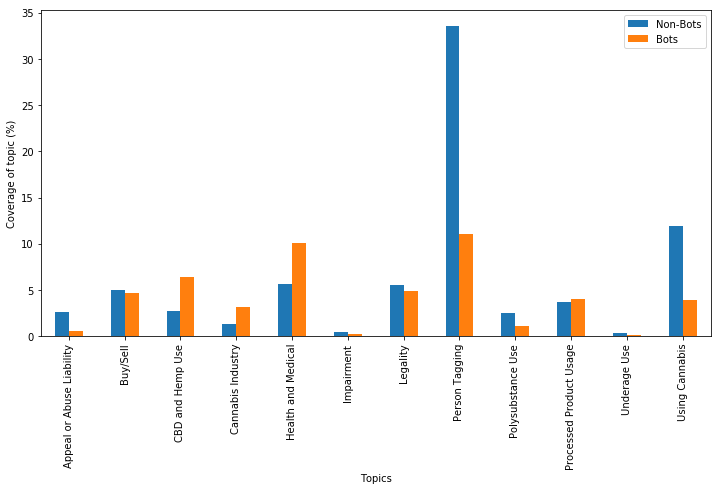

In [31]:
def compare_topics(non_bot_topics, bot_topics, non_bot_tweets, bot_tweets):
    total_bot_tweets = bot_tweets.shape[0]
    total_non_bot_tweets = non_bot_tweets.shape[0]
    
    table = []
    all_topics = sorted(list(set(bot_topics.keys()) | set(non_bot_topics.keys())))
    for topic in all_topics:
        if topic == 'Spam': continue
        row = [topic, 0, 0, 0]
        if topic in non_bot_topics:
            row[1] = len(non_bot_topics[topic]) / total_non_bot_tweets * 100
        if topic in bot_topics:
            row[2] = len(bot_topics[topic]) / total_bot_tweets * 100
        row[3] = row[1] - row[2]
        table.append(row)
    df = pd.DataFrame(table, columns=['Topics', 'Non-Bots', 'Bots', 'Delta']).set_index('Topics')
    display(df)
    ax = df[['Non-Bots', 'Bots']].plot(kind='bar', figsize=(12, 6))
    ax.set_ylabel('Coverage of topic (%)')
    display(ax)

compare_topics(topics, bot_topics, dfs.tweets, bot_dfs.tweets)

## Remaining tweets
Below is the word cloud from the remaining tweets (tweets that weren't already classified into a topic). This should help us identify new topics that have been missed.

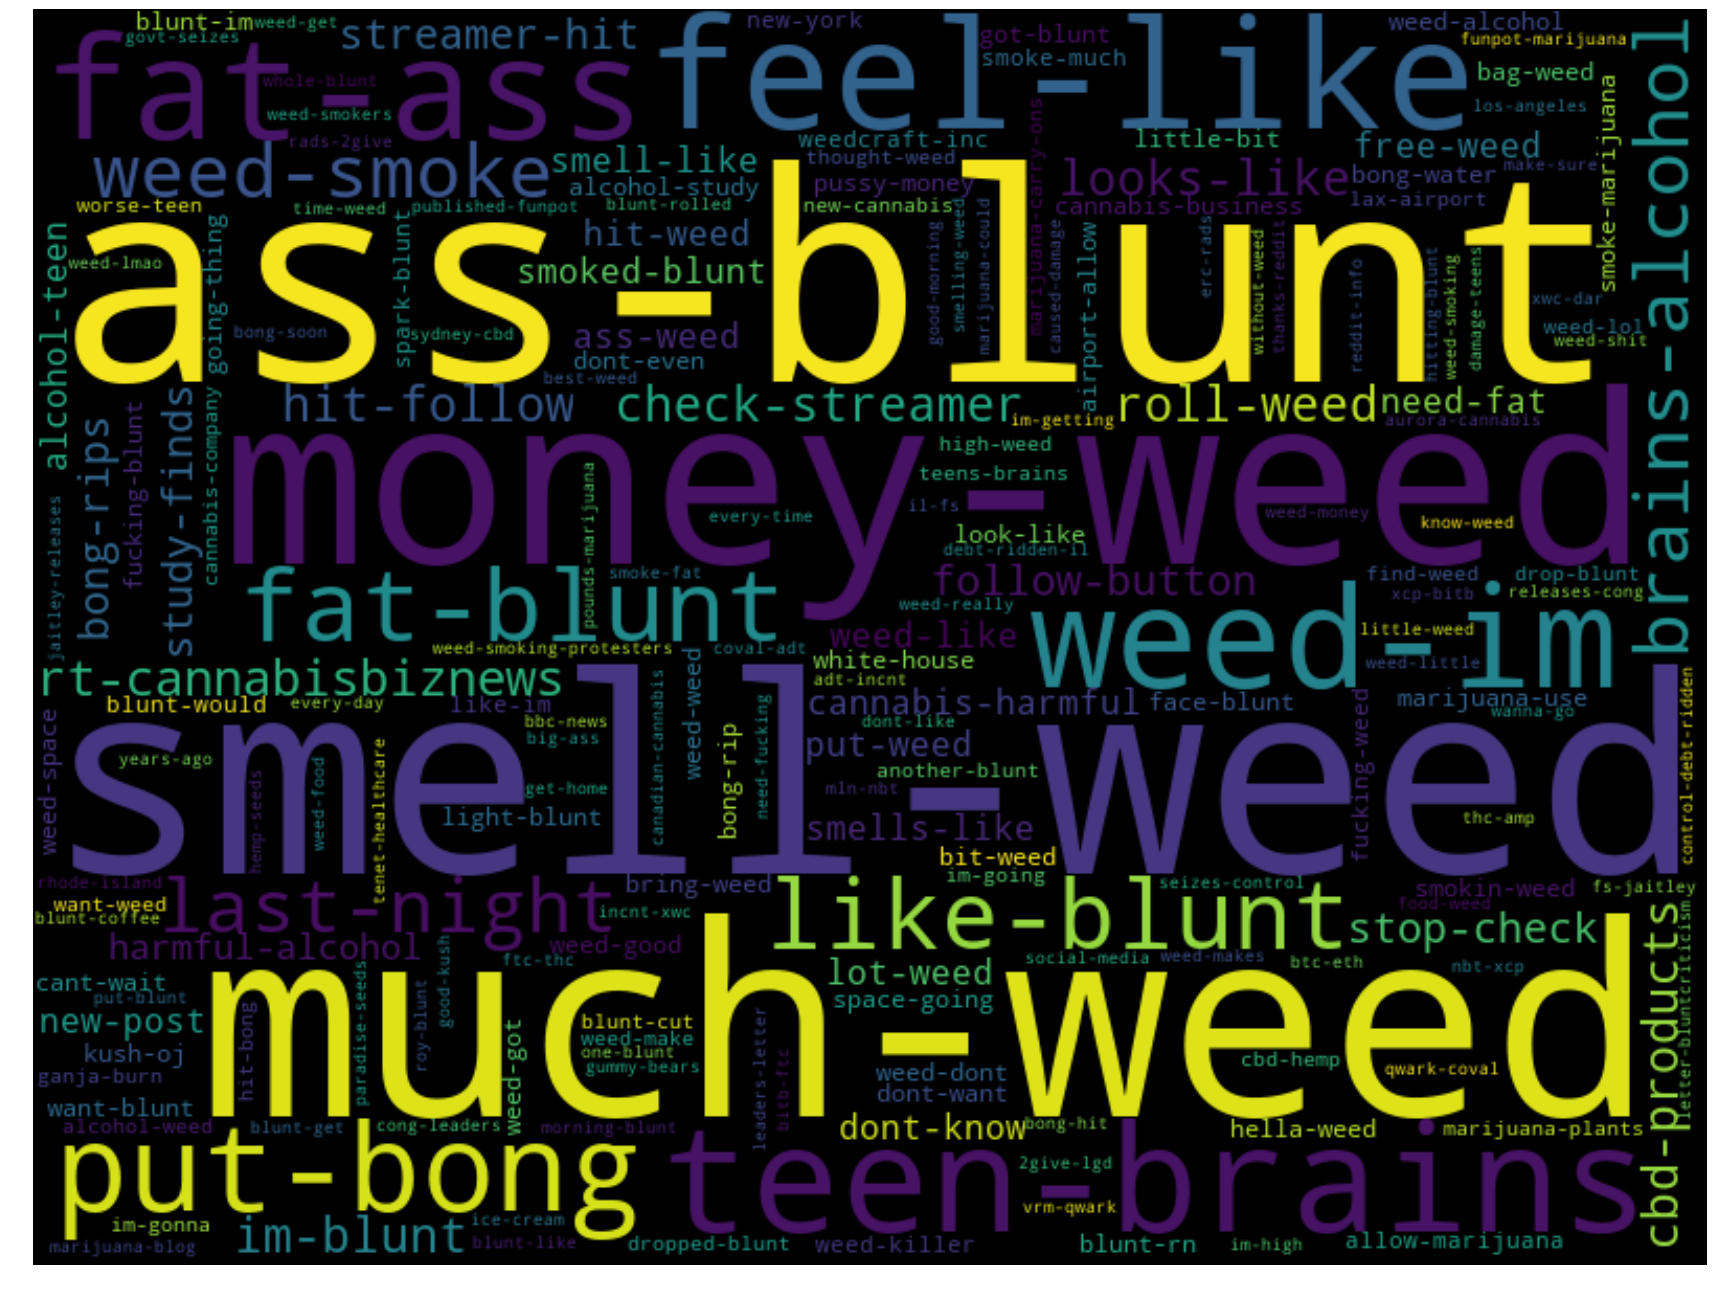

In [32]:
create_wordCloud(gen_ngrams(negatives).bigrams.to_dict()['Freq'])

## Rough work
Everything below is throwaway code used for rough calculations and explorations of the dataset.

In [ ]:
x = dfs.tweets[dfs.tweets.Id.isin(classify(dfs.tweets,
                                          [
                                              ('high', 'school')
                                          ]
                                         ))]

In [ ]:
x.head(50)